# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal /workspace/data/MovieLens/data .

copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2021-02-08 16:23 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-08 16:23 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-08 16:23 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-08 16:23 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-08 16:23 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2021-02-08 16:26 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2021-02-08 16:23 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-08 16:23 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-08 16:23 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-08 16:23 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 7.39 ms, sys: 0 ns, total: 7.39 ms
Wall time: 1.16 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 7.21 ms, sys: 5.6 ms, total: 12.8 ms
Wall time: 34.4 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 59.2 s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 17.5 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (175085, (5.0, ['175085', 'New Order (2012)'])),
 (179621, (5.0, ['179621', 'Frau Holle (2008)'])),
 (182589, (5.0, ['182589', 'Witchcraft 15: Blood Rose (2017)'])),
 (166223, (5.0, ['166223', '"Von einem']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

Py4JJavaError: An error occurred while calling o216.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory hdfs://quickstart.cloudera:8020/user/root/data/ml-25m/movie_avg_rating already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:132)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1179)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1060)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:951)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1457)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1436)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsTextFile(JavaRDDLike.scala:507)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:46)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [ ]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

In [ ]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

In [ ]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

In [ ]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
voice_movie = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

voice_movie \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda m: (m[1][0], m[1][1][1]))\
    .take(10)

[(81491, 'Forrest Gump (1994)'),
 (81482, '"Shawshank Redemption'),
 (79672, 'Pulp Fiction (1994)'),
 (74127, '"Silence of the Lambs'),
 (72674, '"Matrix'),
 (68717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (64144, 'Jurassic Park (1993)'),
 (60411, "Schindler's List (1993)"),
 (59184, 'Braveheart (1995)'),
 (58773, 'Fight Club (1999)')]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
movie_five = ratings \
    .map(lambda r: (r.movie_id, int(r.rating == 5))) \
    .reduceByKey(lambda a, b: a + b)

movie_five = ratings \
    .filter(lambda r: r.rating == 5)\
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

movie_five \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda m: (m[1][0], m[1][1][1]))\
    .take(10)

[(39553, '"Shawshank Redemption'),
 (32169, 'Pulp Fiction (1994)'),
 (25918, 'Forrest Gump (1994)'),
 (25804, 'Star Wars: Episode IV - A New Hope (1977)'),
 (25482, '"Matrix'),
 (24853, "Schindler's List (1993)"),
 (24801, '"Silence of the Lambs'),
 (24418, '"Godfather'),
 (21585, '"Usual Suspects'),
 (21486, 'Fight Club (1999)')]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

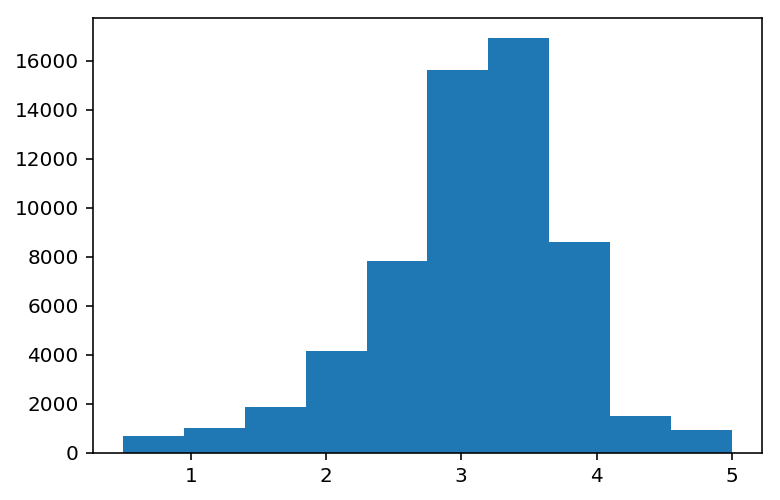

In [26]:
avg_rating = movie_avg_rating.map(lambda m: m[1]).collect()
plt.hist(avg_rating);

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

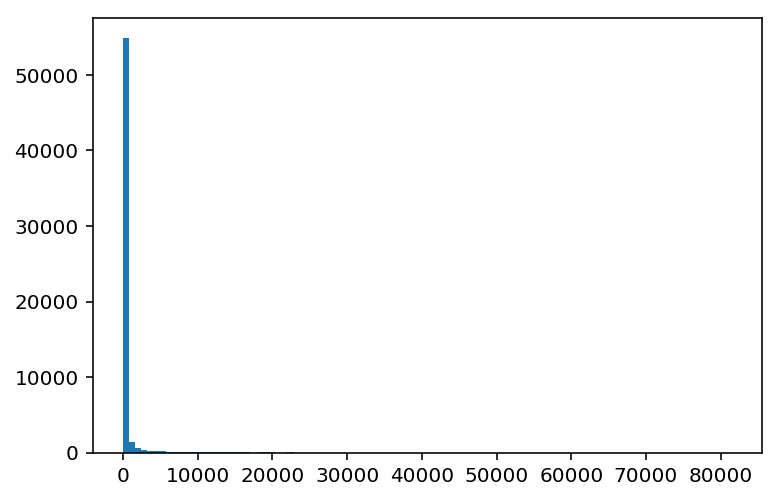

In [27]:
voices = voice_movie.map(lambda m: m[1]).collect()
plt.hist(voices, bins=100);

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [77]:
genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .flatMap(lambda s: [(g, 1) for g in s.split(',')[-1].split('|')])\
    .filter(lambda arr: arr[0] != 'genres')\
    .reduceByKey(lambda a, b: a + b)

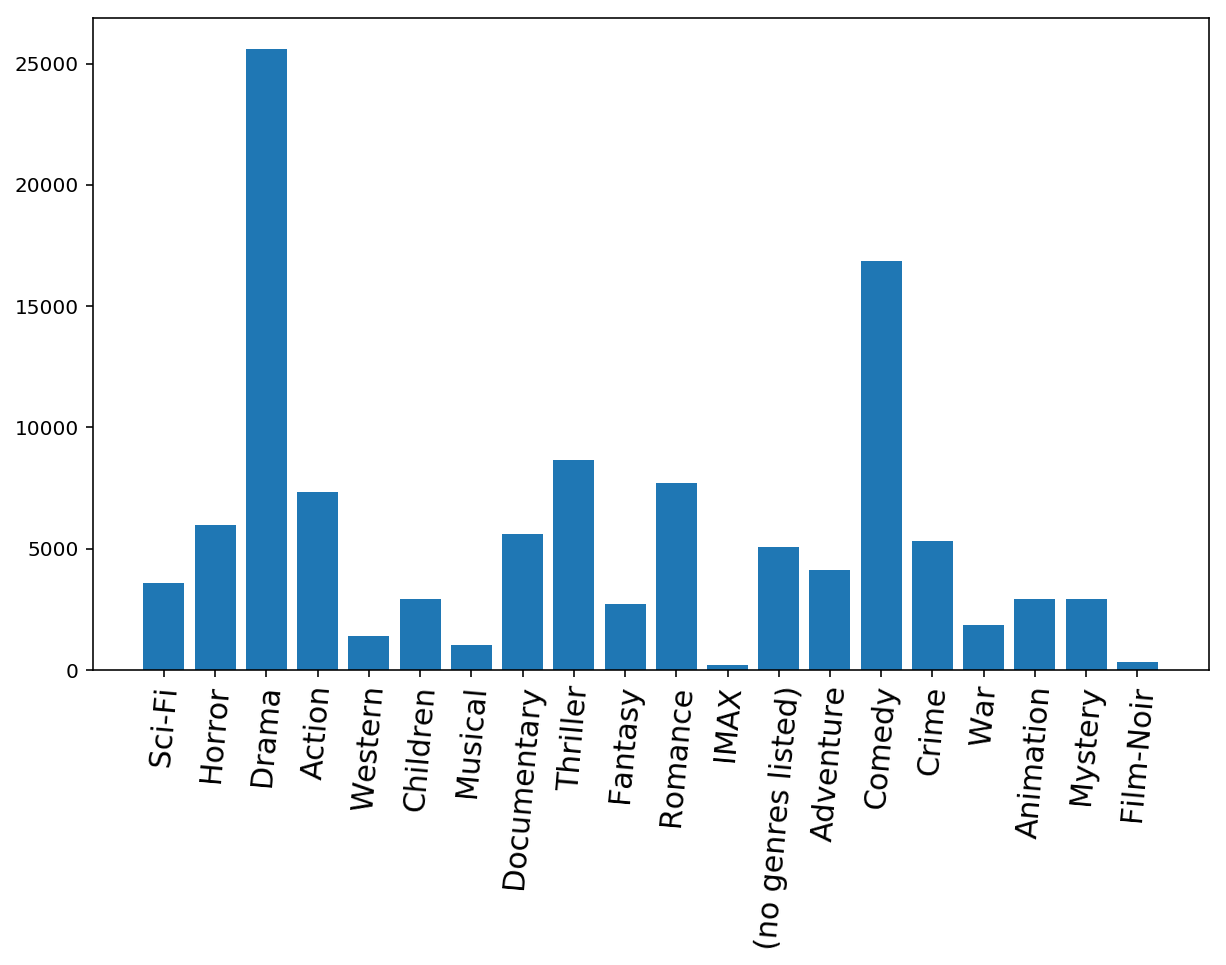

In [80]:
keys, values = zip(*genres.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [85]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, "ratings.csv")
MOVIES_PATH = os.path.join(DATA_PATH, "movies.csv")
LINKS_PATH = os.path.join(DATA_PATH, "links.csv")
TMDB_PATH = os.path.join(DATA_PATH, "tmdb.json")

ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd

In [93]:
movies_ = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: arr[0])
movies_.take(10)

[('1', ['1', 'Toy Story (1995)']),
 ('2', ['2', 'Jumanji (1995)']),
 ('3', ['3', 'Grumpier Old Men (1995)']),
 ('4', ['4', 'Waiting to Exhale (1995)']),
 ('5', ['5', 'Father of the Bride Part II (1995)']),
 ('6', ['6', 'Heat (1995)']),
 ('7', ['7', 'Sabrina (1995)']),
 ('8', ['8', 'Tom and Huck (1995)']),
 ('9', ['9', 'Sudden Death (1995)']),
 ('10', ['10', 'GoldenEye (1995)'])]

In [95]:
tmdb_movie_id = tmdb\
    .filter(lambda row: hasattr(row.casts, "cast") and 31 in [cast.id for cast in row.casts.cast])\
    .map(lambda row: row.id)\
    .keyBy(lambda id: str(id))

In [96]:
tmdb_movie_id.take(5)

[('862', 862), ('568', 568), ('13', 13), ('9800', 9800), ('858', 858)]

In [114]:
links.take(1)

['movieId,imdbId,tmdbId']

In [97]:
links_id = links\
    .map(lambda s: s.split(','))\
    .filter(lambda row: row[0].isdigit())\
    .map(lambda row: (row[0], row[2]))\
    .keyBy(lambda row: row[1])

In [98]:
links_id.take(5)

[('862', ('1', '862')),
 ('8844', ('2', '8844')),
 ('15602', ('3', '15602')),
 ('31357', ('4', '31357')),
 ('11862', ('5', '11862'))]

In [116]:
tmdb_movie_id\
    .join(links_id)\
    .map(lambda row: row[1][1])\
    .keyBy(lambda row: row[0])\
    .join(movies_)\
    .map(lambda row: row[1][1][1])\
    .collect()

['Cast Away (2000)',
 '"Man with One Red Shoe',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Catch Me If You Can (2002)',
 'Extremely Loud and Incredibly Close (2011)',
 'Ithaca (2015)',
 'Toy Story of Terror (2013)',
 '"Terminal',
 "Defying the Nazis: The Sharps' War (2016)",
 'Volunteers (1985)',
 'Toy Story (1995)',
 '"\'burbs',
 'Road to Perdition (2002)',
 'Saving Private Ryan (1998)',
 'Toy Story Toons: Small Fry (2011)',
 '"Green Mile',
 'Angels & Demons (2009)',
 'Cars (2006)',
 'Nothing in Common (1986)',
 'Splash (1984)',
 'Shooting War (2000)',
 'Everything Is Copy (2015)',
 'Mazes and Monsters (1982)',
 'Sully (2016)',
 '"Celluloid Closet',
 'Apollo 13 (1995)',
 '"The Mayo Clinic',
 'Inferno (2016)',
 'Radio Flyer (1992)',
 'Joe Versus the Volcano (1990)',
 'And the Oscar Goes To... (2014)',
 'Killing Lincoln (2013)',
 'The Circle (2016)',
 '"Pixar Story',
 'Elvis Has Left the Building (2004)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Bachelor P

In [129]:
cast_id = tmdb\
    .filter(lambda row: hasattr(row.casts, "cast"))\
    .flatMap(lambda row: [(cast.name, 1) for cast in row.casts.cast])\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda name : name[1], ascending=False)

In [130]:
cast_id.take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [181]:
tmdb\
    .flatMap(lambda row : [(row.release_date, g.name) for g in row.genres])\
    .keyBy(lambda row: row[0])\
    .groupBy(1)\
    .count()\
    .take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 185.0 failed 4 times, most recent failure: Lost task 1.3 in stage 185.0 (TID 567, quickstart.cloudera): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1860, in combine
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "/usr/lib/spark/python/pyspark/rdd.py", line 698, in <lambda>
    return self.map(lambda x: (f(x), x)).groupByKey(numPartitions, partitionFunc)
TypeError: 'int' object is not callable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1843)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1869)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1940)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:927)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:926)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor52.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/worker.py", line 111, in main
    process()
  File "/usr/lib/spark/python/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/lib/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "/usr/lib/spark/python/pyspark/rdd.py", line 1860, in combine
    merger.mergeValues(iterator)
  File "/usr/lib/spark/python/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "/usr/lib/spark/python/pyspark/rdd.py", line 698, in <lambda>
    return self.map(lambda x: (f(x), x)).groupByKey(numPartitions, partitionFunc)
TypeError: 'int' object is not callable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:342)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:306)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:270)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:73)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################